In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

In [3]:
from argparse import Namespace
from pathlib import Path
import torch
from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from turboflow.dataloaders import TurboFlowDataModule
from turboflow.evaluation import compute_all_metrics

from turboflow.utils import phy_utils as phy
from turboflow.utils import torch_utils as tch

In [4]:
seed_everything(42, workers=True)

Global seed set to 42


42

In [5]:
# load dataset
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
dm = TurboFlowDataModule(dataset='Turb2D', 
                         data_dir=data_dir,
                         batch_size=100000,
                         time_idx=0,
                         train_downsampling=8,
                         val_downsampling=8,
                         test_downsampling=1,
                         num_workers=1)
dm.setup()

In [6]:
X_lr, y_lr = dm.val_dataset[:]
img_shape_lr = dm.val_dataset.img_shape[:2]
shape_lr = dm.val_dataset.img_shape
L = shape_lr[0]
N_lr = X_lr.shape[0]
print(N_lr, L)

X_hr, y_hr = dm.test_dataset[:]
img_shape_hr = dm.test_dataset.img_shape[:2]
shape_hr = dm.test_dataset.img_shape
H = shape_hr[0]
N_hr = X_hr.shape[0]
print(N_hr, H)

1024 32
65536 256


In [11]:
from turboflow.models.phyrff_hard import plDivFreeRFFNet

# choose the hyperparams
hparams = {
    'name':'RFFNet',
    'mlp_layers_num': 10,
    'mlp_layers_dim': 256, 
    'mlp_last_actfn': 'tanh',
    'do_rff': True, 
    'rff_num': 512, 
    'rff_scale': 10,
    'do_divfree': True,
    'lam_sdiv': 0,     # spatial grad(u,v) = torch.autograd(u,v)
    'lam_sfn':  0,     # offgrid L2 reg. on Sfun
    'lam_spec': 0,    # L2 diff on the spectrum
    'lam_grads':0,    # offrgid L2 reg. on grad and autograd
    'lam_curl' :0,       # smooth grad of vorticity
    'lam_pde' : 0,
    'lam_weight': 1e-3,  # L2 reg on the NN's weights
    'sfn_min_x': 1./256., # maximal resolution
    'sfn_num_centers': 32,
    'sfn_num_increments':8,
    'sfn_patch_dim': 16 # (P/2)
}

model = plDivFreeRFFNet(**vars(Namespace(**hparams)))

In [12]:
early_stop_callback = EarlyStopping(monitor='val/loss/tot')
checkpoint_callback = ModelCheckpoint(
    monitor="val/loss/tot",
    dirpath=".torch_checkpoints",
    filename="Turb2D-%s-{epoch:02d}-{val_loss:.2f}" % (hparams['name']),
    save_top_k=1,
    mode="min",
)

trainer = Trainer(gpus=1,
                  max_epochs=3000, 
                  log_every_n_steps=20,
                  check_val_every_n_epoch=20, 
                  callbacks=[early_stop_callback,
                             checkpoint_callback])


/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory .torch_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [13]:
trainer.fit(model, dm)

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | rff     | Fourier         | 1.0 K 
1 | mlp     | MLP             | 854 K 
2 | div     | DivFree         | 0     
3 | sp_grad | SpatialGradient | 0     
4 | sp_lapl | Laplacian       | 0     
--------------------------------------------
854 K     Trainable params
1.0 K     Non-trainable params
855 K     Total params
3.423     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1046: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])
torch.Size([1024, 2])


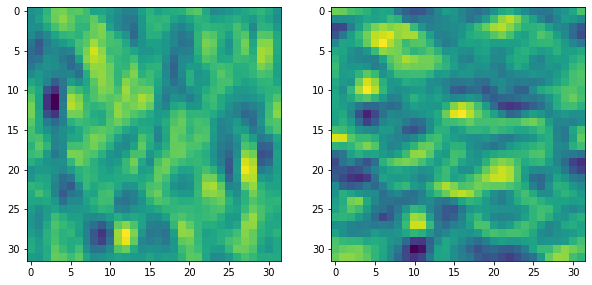

torch.Size([4096, 2])


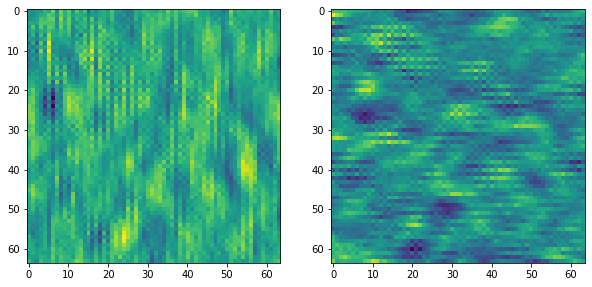

In [14]:
patch_ln = torch.arange(0, 1, 1/64)
print(patch_ln)
R = patch_ln.shape[0]
# make it square meshgrid
patch_sq = torch.stack(torch.meshgrid(patch_ln, patch_ln), dim=-1)
patch_sq = patch_sq.view(-1,2)

X = X_lr
R = int(X.shape[0]**0.5)
y = model(X)[0]
print(y.shape)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(y.reshape(R,R,2).detach().cpu()[:,:,0])
plt.subplot(122)
plt.imshow(y.reshape(R,R,2).detach().cpu()[:,:,1])
plt.show()

X = patch_sq
R = int(X.shape[0]**0.5)
y = model(X)[0]
print(y.shape)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(y.reshape (R,R,2).detach().cpu()[:,:,0])
plt.subplot(122)
plt.imshow(y.reshape(R,R,2).detach().cpu()[:,:,1])
plt.show()


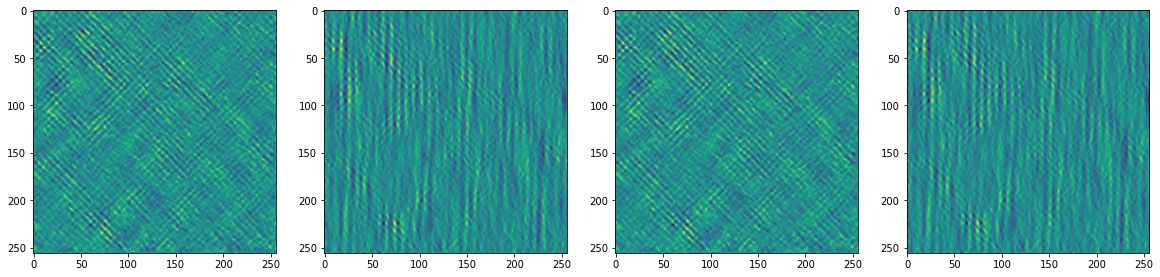

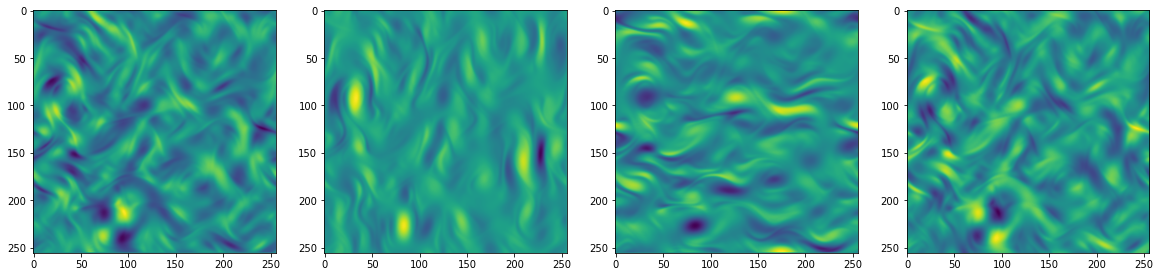

In [15]:
X = X_hr
R = int(X.shape[0]**0.5)

from kornia.filters import SpatialGradient
sp_grad = SpatialGradient(mode='sobel',normalized=True)

X.requires_grad_(True)
y = model(X)[0]
u, v = torch.split(y,1,-1)
du_xy = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0] # Bx2 
dv_xy = torch.autograd.grad(v, X, torch.ones_like(v), create_graph=True)[0] # Bx2

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(du_xy.reshape (R,R,2).detach().cpu()[:,:,0] / (R*2))
plt.subplot(142)
plt.imshow(du_xy.reshape(R,R,2).detach().cpu()[:,:,1] / (R*2))
plt.subplot(143)
plt.imshow(du_xy.reshape (R,R,2).detach().cpu()[:,:,0] / (R*2))
plt.subplot(144)
plt.imshow(du_xy.reshape(R,R,2).detach().cpu()[:,:,1] / (R*2))
plt.show()

y_img_hat = y_hr.view(R,R,2)[None,...].permute(0,3,1,2)
grads = sp_grad(y_img_hat) # Nx2x2xHxW

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(grads[0,0,1,...].detach().numpy())
plt.subplot(142)
plt.imshow(grads[0,0,0,...].detach().numpy())
plt.subplot(143)
plt.imshow(grads[0,1,1,...].detach().numpy())
plt.subplot(144)
plt.imshow(grads[0,1,0,...].detach().numpy())
plt.show()

In [ ]:
checkpoint_callback.best_model_path

In [ ]:
# grads = '/home/dicarlo_d/Documents/Code/TurboSuperResultion/notebooks/.torch_checkpoints/Turb2D-RFFNet-epoch=1019-val_loss=0.01.ckpt'

In [ ]:
X_lr, y_lr = dm.val_dataset[:]
img_shape_lr = dm.val_dataset.img_shape[:2]
shape_lr = dm.val_dataset.img_shape

X_hr, y_hr = dm.test_dataset[:]
img_shape_hr = dm.test_dataset.img_shape[:2]
shape_hr = dm.test_dataset.img_shape

print(X_lr.shape, y_lr.shape)
print(X_hr.shape, y_hr.shape)

y_hat_lr, P_hat_lr = model(X_lr)
y_hat_hr, P_hat_hr = model(X_hr)

print(y_hat_lr.shape)
print(y_hat_hr.shape)

err_lr = torch.abs(y_hat_lr - y_lr)**2
err_hr = torch.abs(y_hat_hr - y_hr)**2

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Pred LR')
plt.imshow(y_hat_lr[:,0].reshape(*img_shape_lr).detach())
plt.subplot(132)
plt.title('GT LR')
plt.imshow(y_lr[:,0].reshape(*img_shape_lr).detach())
plt.subplot(133)
plt.title('Error LR')
plt.imshow(err_lr[:,0].reshape(*img_shape_lr).detach())
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Pred HR')
plt.imshow(y_hat_hr[:,0].reshape(*img_shape_hr).detach())
plt.subplot(132)
plt.title('GT HR')
plt.imshow(y_hr[:,0].reshape(*img_shape_hr).detach())
plt.subplot(133)
plt.title('Error HR')
plt.imshow(err_hr[:,0].reshape(*img_shape_hr)[5:-5,5:-5].detach())
plt.show()

if P_hat_hr is not None:
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Pred LR')
    plt.imshow(P_hat_lr[:,0].reshape(*img_shape_lr).detach())
    plt.subplot(122)
    plt.title('GT LR')
    plt.imshow(P_hat_hr[:,0].reshape(*img_shape_hr).detach())
    plt.show()

In [ ]:
from kornia.filters import SpatialGradient
sp_grad = SpatialGradient(mode='diff',normalized=True)

In [ ]:
res = 64
x = torch.linspace(0, 1, res, device=model.device)
xx, xy = torch.meshgrid([x, x])
x = torch.cat([xx.flatten()[:,None], xy.flatten()[:,None]], dim=-1)
x.requires_grad_(True)
y_hat_off, _ = model.forward(x)

plt.imshow(y_hat_off[:,0].reshape(res,res).detach())
plt.colorbar()
plt.show()

In [ ]:
# compute the spatial gradient of the groundtruth
y_img_hat = y_lr.view(1,L,L,2).permute(0,3,1,2)
grads = sp_grad(y_img_hat)
img_u_x = grads[0,0,1,...] # we take this inverted as it was we are doing ij indexing
img_u_y = grads[0,0,0,...] # we take this inverted as it was we are doing ij indexing
img_v_x = grads[0,1,1,...] # we take this inverted as it was we are doing ij indexing
img_v_y = grads[0,1,0,...] # we take this inverted as it was we are doing ij indexing

plt.figure(figsize=(20,5))
plt.suptitle('Spatial gradient LR')
plt.subplot(141)
plt.imshow(img_u_x.detach())
plt.subplot(142)
plt.imshow(img_u_y.detach())
plt.subplot(143)
plt.imshow(img_v_x.detach())
plt.subplot(144)
plt.imshow(img_v_y.detach())
plt.colorbar()
plt.show()

# compute the spatial gradient of the prediction
y_img_hat = y_hat_off.view(1,res,res,2).permute(0,3,1,2)
grads = sp_grad(y_img_hat)
img_u_x = grads[0,0,1,...] # we take this inverted as it was we are doing ij indexing
img_u_y = grads[0,0,0,...] # we take this inverted as it was we are doing ij indexing
img_v_x = grads[0,1,1,...] # we take this inverted as it was we are doing ij indexing
img_v_y = grads[0,1,0,...] # we take this inverted as it was we are doing ij indexing

plt.figure(figsize=(20,5))
plt.suptitle('Spatial gradient HR')
plt.subplot(141)
plt.imshow(img_u_x.detach())
plt.subplot(142)
plt.imshow(img_u_y.detach())
plt.subplot(143)
plt.imshow(img_v_x.detach())
plt.subplot(144)
plt.imshow(img_v_y.detach())
plt.colorbar()
plt.show()

# compute the gradient of the prediction with autograd
u, v = torch.split(y_hat_off,1,-1)
du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]

du_x = du_xy[:,0].reshape(res,res) / res
du_y = du_xy[:,1].reshape(res,res) / res
dv_x = dv_xy[:,0].reshape(res,res) / res
dv_y = dv_xy[:,1].reshape(res,res) / res

plt.figure(figsize=(20,5))
plt.suptitle('Autograd gradient HR')
plt.subplot(141)
plt.imshow(du_x.detach())
plt.subplot(142)
plt.imshow(du_y.detach())
plt.subplot(143)
plt.imshow(dv_x.detach())
plt.subplot(144)
plt.imshow(dv_y.detach())
plt.colorbar()
plt.show()

gdiff_u_x = torch.abs(img_u_x - du_x)**1
gdiff_u_y = torch.abs(img_u_y - du_y)**1
gdiff_v_x = torch.abs(img_v_x - dv_x)**1
gdiff_v_y = torch.abs(img_v_y - dv_y)**1

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(gdiff_u_x.detach().cpu())
plt.subplot(142)
plt.imshow(gdiff_u_y.detach().cpu())
plt.subplot(143)
plt.imshow(gdiff_v_x.detach().cpu())
plt.subplot(144)
plt.imshow(gdiff_v_y.detach().cpu())
plt.colorbar()
plt.show()

In [ ]:
w = dv_x - du_y
plt.imshow(w.detach().cpu())

In [ ]:
x = X_lr[:,0].detach()
y = X_lr[:,1].detach()
u = y_hat_lr[:,0].detach()
v = y_hat_lr[:,1].detach()

s = 1
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.quiver(x.reshape(*img_shape_lr)[::s,::s], 
           y.reshape(*img_shape_lr)[::s,::s],
           u.reshape(*img_shape_lr)[::s,::s],
           v.reshape(*img_shape_lr)[::s,::s], scale=10)
plt.subplot(122)
plt.quiver(        x.reshape(*img_shape_lr)[::s,::s], 
                   y.reshape(*img_shape_lr)[::s,::s],
           y_lr[:,0].reshape(*img_shape_lr)[::s,::s],
           y_lr[:,1].reshape(*img_shape_lr)[::s,::s], scale=10)

In [ ]:
x = X_lr[:,0].detach()
y = X_lr[:,1].detach()
u_diff = y_hat_lr[:,0].detach() - y_lr[:,0].detach()
v_diff = y_hat_lr[:,1].detach() - y_lr[:,1].detach()

s = 1
plt.figure(figsize=(10,10))
plt.quiver(x.reshape(*img_shape_lr)[::s,::s], 
           y.reshape(*img_shape_lr)[::s,::s],
           u_diff.reshape(*img_shape_lr)[::s,::s],
           v_diff.reshape(*img_shape_lr)[::s,::s], scale=10)

In [ ]:
s = 1
plt.figure(figsize=(10,10))
plt.streamplot(        
           x.reshape(*img_shape_lr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           y_lr[:,0].reshape(*img_shape_lr)[::s,::s].T.numpy(),
           y_lr[:,1].reshape(*img_shape_lr)[::s,::s].T.numpy(), density=2)
plt.streamplot(x.reshape(*img_shape_lr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           u.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           v.reshape(*img_shape_lr)[::s,::s].T.numpy(), density=2)

In [ ]:
x = X_hr[:,0].detach()
y = X_hr[:,1].detach()
u = y_hat_hr[:,0].detach()
v = y_hat_hr[:,1].detach()

s = 4
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.quiver(x.reshape(*img_shape_hr)[::s,::s], 
           y.reshape(*img_shape_hr)[::s,::s],
           u.reshape(*img_shape_hr)[::s,::s],
           v.reshape(*img_shape_hr)[::s,::s], scale=10)
plt.subplot(122)
plt.quiver(        x.reshape(*img_shape_hr)[::s,::s], 
                   y.reshape(*img_shape_hr)[::s,::s],
           y_hr[:,0].reshape(*img_shape_hr)[::s,::s],
           y_hr[:,1].reshape(*img_shape_hr)[::s,::s], scale=10)


x = X_hr[:,0].detach()
y = X_hr[:,1].detach()
u_diff = y_hat_hr[:,0].detach() - y_hr[:,0].detach()
v_diff = y_hat_hr[:,1].detach() - y_hr[:,1].detach()

plt.figure(figsize=(10,10))
plt.quiver(x.reshape(*img_shape_hr)[::s,::s], 
           y.reshape(*img_shape_hr)[::s,::s],
           u_diff.reshape(*img_shape_hr)[::s,::s],
           v_diff.reshape(*img_shape_hr)[::s,::s], scale=10)
plt.show()

In [ ]:
s = 1
plt.figure(figsize=(20,20))
plt.streamplot(
           x.reshape(*img_shape_hr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           u.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           v.reshape(*img_shape_hr)[::s,::s].T.numpy(),density=3)
plt.streamplot(        
           x.reshape(*img_shape_hr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           y_hr[:,0].reshape(*img_shape_hr)[::s,::s].T.numpy(),
           y_hr[:,1].reshape(*img_shape_hr)[::s,::s].T.numpy(),density=3)

In [ ]:
x = X_hr[:,0].detach()
y = X_hr[:,1].detach()
u = y_hat_hr[:,0].detach()
v = y_hat_hr[:,1].detach()

d = 1
l = 64
s = 10
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.quiver(x.reshape(*img_shape_hr)[:l:d,:l:d], 
           y.reshape(*img_shape_hr)[:l:d,:l:d],
           u.reshape(*img_shape_hr)[:l:d,:l:d],
           v.reshape(*img_shape_hr)[:l:d,:l:d], scale=s)
plt.subplot(122)
plt.quiver(        x.reshape(*img_shape_hr)[:l:d,:l:d], 
                   y.reshape(*img_shape_hr)[:l:d,:l:d],
           y_hr[:,0].reshape(*img_shape_hr)[:l:d,:l:d],
           y_hr[:,1].reshape(*img_shape_hr)[:l:d,:l:d], scale=s)

In [ ]:
x = X_hr[:,0].detach()
y = X_hr[:,1].detach()
u = y_hat_hr[:,0].detach()
v = y_hat_hr[:,1].detach()

d = 1
l = 64
s = 10
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(u.reshape(*img_shape_hr)[:l:d,:l:d])
plt.subplot(122)
plt.imshow(y_hr[:,0].reshape(*img_shape_hr)[:l:d,:l:d])
plt.show()
plt.imshow((y_hr[:,0]-u).reshape(*img_shape_hr)[:l:d,:l:d])
plt.colorbar()

In [ ]:
print(compute_all_metrics(y_hat_lr, y_lr))
print(compute_all_metrics(y_hat_hr, y_hr))

In [ ]:
# compute spectrum
spec_ns = phy.energy_spectrum(torch.randn(*shape_hr).permute(2,0,1))[0]
spec_lr = phy.energy_spectrum(y_lr.view(*shape_lr).permute(2,0,1))[0]
spec_hr = phy.energy_spectrum(y_hr.view(*shape_hr).permute(2,0,1))[0]

spec_lr_pred = phy.energy_spectrum(y_hat_lr.view(*shape_lr).permute(2,0,1))[0]
spec_hr_pred = phy.energy_spectrum(y_hat_hr.view(*shape_hr).permute(2,0,1))[0]

# plt.loglog(spec_ns)
plt.loglog(spec_lr)
plt.loglog(spec_hr)
plt.loglog(spec_lr_pred.detach())
plt.loglog(spec_hr_pred.detach())


In [ ]:
err = (spec_hr - spec_hr_pred)
plt.plot(err.detach())
plt.plot(spec_hr.detach())
plt.plot(spec_hr_pred.detach())
print(err.sum())
print()
# spec error
# spec_log_error_lr = torch.norm(torch.log(spec_lr_pred+1e-20) - torch.log(spec_lr+1e-20))**2
# spec_log_error_hr = torch.norm(torch.log(spec_hr_pred+1e-20) - torch.log(spec_hr+1e-20))**2

# print(spec_error_lr.item())
# print(spec_error_hr.item())

In [ ]:
# angular error
def ang_error(x, x_ref, avg=True):
    assert x.shape == x_ref.shape
    assert x.shape[1] == 2
    N = x.shape[0]
    
    w1 = torch.cat([x, torch.ones(x.shape[0], 1)], dim=1)
    w2 = torch.cat([x_ref, torch.ones(x_ref.shape[0], 1)], dim=1)
    
    err = torch.sum(w1 * w2, dim=1) / (torch.norm(w1, dim=1) * torch.norm(w2, dim=1))
    assert err.sum() < N
    err = torch.rad2deg(torch.acos(err))
    if avg:
        return err.mean()
    return err
    

ang_err_lr = ang_error(y_lr, y_hat_lr, avg=True)
ang_err_hr = ang_error(y_hr, y_hat_hr, avg=True)

print(torch.max(ang_error(y_lr, y_hat_lr, avg=False)))
print(torch.max(ang_error(y_hr, y_hat_hr, avg=False)))


In [ ]:
model = plDivFreeRFFNet.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.test(model, dm)

In [ ]:
spec_lr_err = phy.energy_spectrum(((y_hat_lr-y_lr)**2).view(*img_shape_lr).permute(2,0,1))[0]
spec_hr_err = phy.energy_spectrum(((y_hat_hr-y_hr)**2).view(*img_shape_hr).permute(2,0,1))[0]

plt.loglog(spec_lr_err.detach())
plt.loglog(spec_hr_err.detach())

In [ ]:
y_hat, Py_hat = model(X_lr)
u, v = torch.split(y_hat,1,-1)
du_xy = torch.autograd.grad(u, X_lr, torch.ones_like(u), create_graph=True)[0]       
dv_xy = torch.autograd.grad(v, X_lr, torch.ones_like(v), create_graph=True)[0]
# div_autograd = du_xy[...,0] + dv_xy[...,1]
div_autograd = dv_xy[...,1]
div_autograd = div_autograd.view(*img_shape_lr[:2])

plt.imshow(div_autograd.detach())
plt.colorbar()
plt.show()

du_x = tch._my_field_grad(y_hat.view(*img_shape_lr)[:,:,0], 1)
du_y = tch._my_field_grad(y_hat.view(*img_shape_lr)[:,:,1], 0)
div_numerical = du_y
    
plt.imshow(div_numerical.detach())
plt.colorbar()
plt.show()

plt.imshow((div_numerical - div_autograd).detach())
plt.colorbar()
plt.show()


In [ ]:
y_hat, Py_hat = model(X_hr)
u, v = torch.split(y_hat,1,-1)
du_xy = torch.autograd.grad(u, X_hr, torch.ones_like(u), create_graph=True)[0]       
dv_xy = torch.autograd.grad(v, X_hr, torch.ones_like(v), create_graph=True)[0]
# div_autograd = du_xy[...,0] + dv_xy[...,1]
div_autograd = dv_xy[...,1]
div_autograd = div_autograd.view(*img_shape_hr[:2])

plt.imshow(div_autograd[2:-2,2:-2].detach())
plt.colorbar()
plt.show()

du_x = tch._my_field_grad(y_hat.view(*img_shape_hr)[:,:,0], 1)
du_y = tch._my_field_grad(y_hat.view(*img_shape_hr)[:,:,1], 0)
div_numerical = du_y
    
plt.imshow(div_numerical[2:-2,2:-2].detach())
plt.colorbar()
plt.show()

plt.imshow((div_numerical[2:-2,2:-2] - div_autograd[2:-2,2:-2]).detach())
plt.colorbar()
plt.show()
